## HAR 데이터

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt'
feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()

In [2]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

X_train.columns = feature_name
X_test.columns = feature_name

In [4]:
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None)
y_test = pd.read_csv(y_test_url, sep='\s+', header=None)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

### 재사용을 위해 함수로 만들고(이전 것을 복사)

In [6]:
from sklearn.decomposition import PCA

def get_pca_data(ss_data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    
    return pca.transform(ss_data), pca

### PCA fit

In [7]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pca.shape

(7352, 2)

In [9]:
pca.mean_.shape, pca.components_.shape

((561,), (2, 561))

### 조금 더 재미있는 함수로 만들기 위해

In [10]:
cols = ['pca_' + str(n) for n in range(pca.components_.shape[0])]
cols

['pca_0', 'pca_1']

### PCA 결과를 저장하는 함수

In [11]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_' + str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

### components 2개

In [12]:
HAR_pca, pca = get_pca_data(X_train, n_components=2)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train
HAR_pd_pca.head()

,pca_0,pca_1,action
0,-5.520280,-0.290278,5
1,-5.535350,-0.082530,5
2,-5.474988,0.287387,5
3,-5.677232,0.897031,5
4,-5.748749,1.162952,5


### 시각화

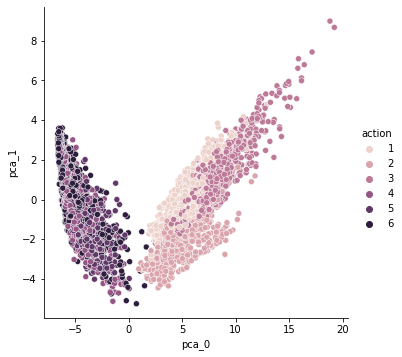

In [13]:
import seaborn as sns

sns.pairplot(HAR_pd_pca, hue='action', height=5,
            x_vars=['pca_0'], y_vars=['pca_1']);

- 구분이 잘 안되는 데이터들이 존재한다

### 전체 500개가 넘는 특성을 단 2개로 줄이면

In [14]:
import numpy as np

def print_variance_ratio(pca):
    print('variance_ratio: ', pca.explained_variance_ratio_)
    print('sum of variance_ratio: ', np.sum(pca.explained_variance_ratio_))
    
print_variance_ratio(pca)

variance_ratio:  [0.6255444  0.04913023]
sum of variance_ratio:  0.674674627048794


### 컴포넌트 3개로

In [15]:
HAR_pca, pca = get_pca_data(X_train, n_components=3)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio:  [0.6255444  0.04913023 0.04121467]
sum of variance_ratio:  0.715889301578533


### 컴포넌트 10개

In [16]:
HAR_pca, pca = get_pca_data(X_train, n_components=10)
HAR_pd_pca = get_pd_from_pca(HAR_pca, pca.components_.shape[0])
HAR_pd_pca['action'] = y_train

print_variance_ratio(pca)

variance_ratio:  [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.0096938  0.00858017]
sum of variance_ratio:  0.8050387030974664


### 혹시 이 결과가 시간이 길게 나왔다면 지금은?

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': [6, 8, 10],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(HAR_pca, y_train.values.reshape(-1,))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

#### 성능 확인

In [18]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators',
             'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
17,1,0.837459,200,8
29,1,0.837459,200,10
26,1,0.837459,200,10
14,1,0.837459,200,8
32,5,0.837323,200,10


In [19]:
# best 파라미터
grid_cv.best_params_, grid_cv.best_score_

({'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 8,
  'n_estimators': 200},
 0.8374591947769314)

#### 테스트 데이터에 적용

In [20]:
from sklearn.metrics import accuracy_score

rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(HAR_pca, y_train.values.reshape(-1))

pred1 = rf_clf_best.predict(pca.transform(X_test)) # train데이터로 학습을 완료헌 pca로 transform

accuracy_score(y_test, pred1)

0.8523922633186292

### 시간이 많이 걸렸던 xgboost는?

In [21]:
%%time

from xgboost import XGBClassifier

evals = [(pca.transform(X_test), y_test)]

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(HAR_pca, y_train.values.reshape(-1,),
        early_stopping_rounds=10, eval_set=evals)

[13:38:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.61430
[1]	validation_0-mlogloss:1.47582
[2]	validation_0-mlogloss:1.35829
[3]	validation_0-mlogloss:1.26288
[4]	validation_0-mlogloss:1.18060
[5]	validation_0-mlogloss:1.11089
[6]	validation_0-mlogloss:1.04528
[7]	validation_0-mlogloss:0.98940
[8]	validation_0-mlogloss:0.94054
[9]	validation_0-mlogloss:0.89269
[10]	validation_0-mlogloss:0.85080
[11]	validation_0-mlogloss:0.81190


C:\Users\seonwook\miniconda3\envs\ds_study\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\seonwook\miniconda3\envs\ds_study\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[12]	validation_0-mlogloss:0.78038
[13]	validation_0-mlogloss:0.74929
[14]	validation_0-mlogloss:0.72308
[15]	validation_0-mlogloss:0.69774
[16]	validation_0-mlogloss:0.67642
[17]	validation_0-mlogloss:0.65533
[18]	validation_0-mlogloss:0.63738
[19]	validation_0-mlogloss:0.61859
[20]	validation_0-mlogloss:0.60236
[21]	validation_0-mlogloss:0.58854
[22]	validation_0-mlogloss:0.57272
[23]	validation_0-mlogloss:0.55934
[24]	validation_0-mlogloss:0.54675
[25]	validation_0-mlogloss:0.53553
[26]	validation_0-mlogloss:0.52527
[27]	validation_0-mlogloss:0.51504
[28]	validation_0-mlogloss:0.50606
[29]	validation_0-mlogloss:0.49724
[30]	validation_0-mlogloss:0.48981
[31]	validation_0-mlogloss:0.48202
[32]	validation_0-mlogloss:0.47451
[33]	validation_0-mlogloss:0.46775
[34]	validation_0-mlogloss:0.46198
[35]	validation_0-mlogloss:0.45608
[36]	validation_0-mlogloss:0.45018
[37]	validation_0-mlogloss:0.44534
[38]	validation_0-mlogloss:0.44088
[39]	validation_0-mlogloss:0.43537
[40]	validation_0-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### accuracy

In [22]:
accuracy_score(y_test, xgb.predict(pca.transform(X_test)))

0.8656260604004072